## Mining Massive Datasets
### Anastasiia Kasprova

### Homework 3

#### Detecting bots in wikipedia streaming data:

● Consider all the changes than in the wikipedia as stream.
    
    ○ Check here: https://wikitech.wikimedia.org/wiki/RCStream
    
● Each action is received in json format.

● Data is full of bots. There is a flag were programmers can
indicate that an actions has been done by a bot.

● Using this information as ground truth, develop a system able
to classify actions.

● Constrain: You need to sample, and just use the 20% of the
data stream.

--------------

#### 1. Collecting the data from the wikimedia for 20 minutes during 3 days using the following script  (files in data3 folder attached)

In [ ]:
#writing streaming data into dataset.json file

import json
from time import time

from sseclient import SSEClient as EventSource

json_array = []

minutes = 20
users = {}
url = 'https://stream.wikimedia.org/v2/stream/recentchange'

start = time()
for event in EventSource(url):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
            json_array.append(change) 
        except ValueError:
            pass
    if time() - start >= 60 * minutes:
        json_string = json.dumps(json_array)
        break
            
with open("dataset.json","w+") as file: #dataset1.json,dataset2.json,dataset3.json
  file.write(json_string)  
print(time()-start)

#### 2. Now let's read the data and see what we get

In [3]:
import pandas as pd
import numpy as np

In [4]:
# previously we've got 3 files
data1 = pd.read_json("data3/dataset1.json")
data2 = pd.read_json("data3/dataset2.json")
data3 = pd.read_json("data3/dataset3.json")

In [37]:
#let's merge those 3 datasets
data = pd.concat([data1,data2,data3])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81966 entries, 0 to 26517
Data columns (total 23 columns):
bot                   81966 non-null bool
comment               81966 non-null object
id                    80234 non-null float64
length                49530 non-null object
log_action            4243 non-null object
log_action_comment    4243 non-null object
log_id                4243 non-null float64
log_params            4243 non-null object
log_type              4243 non-null object
meta                  81966 non-null object
minor                 49530 non-null float64
namespace             81966 non-null int64
parsedcomment         81966 non-null object
patrolled             33667 non-null float64
revision              49530 non-null object
server_name           81966 non-null object
server_script_path    81966 non-null object
server_url            81966 non-null object
timestamp             81966 non-null datetime64[ns]
title                 81966 non-null object
type   

In [7]:
data[["bot","id","user","type"]].head(5)

,bot,id,user,type
0,False,798673176.0,XierZhanmusi,categorize
1,True,263239980.0,QBA-bot,log
2,False,970209847.0,Tintin456,edit
3,False,565925371.0,Jon Harald Søby,edit
4,False,970209848.0,Huligan0,edit


In [38]:
data[["id"]] = data[["id"]].astype(str)

#### 3. Features extraction
Let's consider 2 features: 

1) how many events user has in the last minute 

2) type of post. 
* We could also consider 'user' data, but it is obvious from the name if it is bot or not.

*In my next data manipulations I will use SQL since I feel really confident with what I am doing thou:D

In [9]:
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

In [35]:
data[["bot","id","user","type","timestamp"]].head(5)

,bot,id,user,type,timestamp
0,False,798673176.0,XierZhanmusi,categorize,2017-08-05 21:26:36
1,True,263239980.0,QBA-bot,log,2017-08-05 21:26:37
2,False,970209847.0,Tintin456,edit,2017-08-05 21:26:37
3,False,565925371.0,Jon Harald Søby,edit,2017-08-05 21:26:37
4,False,970209848.0,Huligan0,edit,2017-08-05 21:26:37


In [199]:
#extracting date, hour and minute from timestamp
df = pd.DataFrame(np.column_stack([data[["bot","id","user","type","timestamp"]],
                                   data["timestamp"].dt.date,
                                   data["timestamp"].dt.hour,
                                   data["timestamp"].dt.minute]),
           columns=["bot","id","user","type","timestamp","date","hour","minute"])

In [198]:
#checking how type depends on bot/not a bot
pysql("select type, bot, count(*) from df group by 1,2 order by 1,2 ")

,type,bot,count(*)
0,142,0,24
1,categorize,0,21041
2,categorize,1,7128
3,edit,0,28770
4,edit,1,11027
5,log,0,3404
6,log,1,839
7,new,0,1837
8,new,1,7896


In [256]:
#counting events per minute for each unique user name
df_train = pysql("select t1.bot, t1.type, t2.events_per_minute \
      from df t1 \
      left join ( \
          select user, date, hour, minute, count(*) as events_per_minute\
          from df \
          group by 1,2,3,4) t2  \
      on t1.user = t2.user \
      and t1.date = t2.date \
      and t1.hour = t2.hour \
      and t1.minute = t2.minute \
      where type != '142'\
      ")

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81966 entries, 0 to 81965
Data columns (total 3 columns):
bot                  81966 non-null int64
type                 81966 non-null object
events_per_minute    81966 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [257]:
#let's encode nominal column type" with one-hot encoding:
type_nominal = pd.get_dummies(df_train["type"])
type_nominal.head(5)

,categorize,edit,log,new
0,1,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [258]:
#building y_train dataset
y_train = df_train["bot"]

In [259]:
#building X_train dataset
X_train = pd.concat([df_train["events_per_minute"], type_nominal], axis = 1)

In [260]:
pd.concat([X_train, y_train], axis = 1).head(2)

,events_per_minute,categorize,edit,log,new,bot
0,1,1,0,0,0,0
1,1,0,0,1,0,1


In [261]:
# "events_per_minute" feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train["events_per_minute"] = sc_X.fit_transform(X_train["events_per_minute"])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [262]:
X_train.head()

,events_per_minute,categorize,edit,log,new
0,-0.52236,1,0,0,0
1,-0.52236,0,0,1,0
2,-0.52236,0,1,0,0
3,-0.49020,0,1,0,0
4,-0.52236,0,1,0,0


#### 5. Modelling 
Let's try different classification models and see which one will give us best result

1. Logistic regression

2. K-Nearest neighbours

3. SVM 

4. Naive Bayes

5. Decision Tree Classification

6. Random Forest Classification

7. XGBoost Classification

##### 5.1. Logistic regression model

In [263]:
from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression(random_state = 42)
classifier_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [264]:
model_lr = classifier_lr.fit(X_train,y_train)

##### 5.2 K-Nearest neighbours

In [265]:
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(n_neighbors = 5, 
                                     metric = "minkowski", p=2)
classifier_KNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [266]:
model_KNN = classifier_KNN.fit(X_train,y_train)

##### 5.3 Support Vector Machine model

In [267]:
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = "linear", random_state = 42)
classifier_SVM.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [268]:
model_SVM = classifier_SVM.fit(X_train,y_train)

##### 5.4 Naive Bayes model

In [269]:
from sklearn.naive_bayes import GaussianNB
classifier_NB = GaussianNB()
classifier_NB.fit(X_train,y_train)

GaussianNB(priors=None)

In [270]:
model_NB = classifier_NB.fit(X_train,y_train)

##### 5.5 Decision Tree Classification model

In [271]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(criterion = "entropy",
                                      random_state = 42)
classifier_DT.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [272]:
model_DT = classifier_DT.fit(X_train,y_train)

##### 5.6 Random Forest model

In [273]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators=10,
                                      random_state = 42,
                                      criterion = "entropy")
classifier_RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [274]:
model_RF = classifier_RF.fit(X_train,y_train)

##### 5.7 XGBoost model 

In [294]:
import xgboost as xgb

classifier_xgb = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=4,
    seed=42)
classifier_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

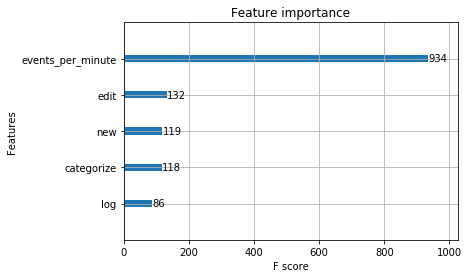

In [276]:
#let's check feature importance in XGBoost model
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model_xgb)
pyplot.show()

In [277]:
#confusion matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)

#### 6. Sampler - filter_data() function
To test our models we need a sample of data that just contains 20% of the data stream (according to the task). For realization we will use the following approach:
knowing that each bot user has his/her/its own id we will devide this integer number on 10. If a remaining is (let's say) 3 or 5 we will include this record to our sample, thus forming our 20% of the streaming data

In [278]:
def filter_data(streaming_data):
    if streaming_data["id"] is not None:
        if (streaming_data["id"]%10 == 3) | (streaming_data["id"]%10 == 5):
            return streaming_data

In [175]:
#collecting sampler
array = []
minutes = 5

json_string = None
start = time()
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
for event in EventSource(url):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
            if filter_data(change):
                array.append(change)
            if time() - start >= 60 * minutes:
                json_string = json.dumps(array)
                break
        except ValueError:
            pass

In [216]:
def convert_data(json):
    df = pd.read_json(json)
    return df

(1346, 23)

In [245]:
sampler_data = convert_data(json_string)
df_test = pd.DataFrame(np.column_stack([sampler_data[["bot","user","type","timestamp"]],
                                   sampler_data["timestamp"].dt.date,
                                   sampler_data["timestamp"].dt.hour,
                                   sampler_data["timestamp"].dt.minute]),
           columns=["bot","user","type","timestamp","date","hour","minute"])
df_test = pysql("select t1.bot, t1.type, t2.events_per_minute \
      from df_test t1 \
      left join ( \
          select user, date, hour, minute, count(*) as events_per_minute\
          from df_test \
          group by 1,2,3,4) t2  \
      on t1.user = t2.user \
      and t1.date = t2.date \
      and t1.hour = t2.hour \
      and t1.minute = t2.minute \
      ")
type_nominal_test = pd.get_dummies(df_test["type"])

data_test = pd.concat([df_test["events_per_minute"],type_nominal_test,df_test["bot"]], axis = 1)
data_test["events_per_minute"] = sc_X.fit_transform(data_test["events_per_minute"])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [246]:
#splitting data into X_test and y_test
def split(data):
    return data.drop('bot', 1),data["bot"]

X_test, y_test = split(data_test)
print(X_test.shape, y_test.shape)

(1346, 5) (1346,)


#### 7. Predicting the test results

In [280]:
X_test.head(3)

,events_per_minute,categorize,edit,log,new
0,-0.888134,0,1,0,0
1,-0.610708,0,0,0,1
2,0.221570,1,0,0,0


In [281]:
X_train.head(3)

,events_per_minute,categorize,edit,log,new
0,-0.52236,1,0,0,0
1,-0.52236,0,0,1,0
2,-0.52236,0,1,0,0


In [295]:
# logistic regression
y_pred_lr = classifier_lr.predict(X_test)

# k-nearest neighors
y_pred_KNN = classifier_KNN.predict(X_test)

# support vector machine
y_pred_SVM = classifier_SVM.predict(X_test)

# naive bayes
y_pred_NB = classifier_NB.predict(X_test)

# decision tree
y_pred_DT = classifier_DT.predict(X_test)

# random forest
y_pred_RF = classifier_RF.predict(X_test)

# xgboost
y_pred_xgb = classifier_xgb.predict(X_test)

#### 8. ROC AUC Score

In [296]:
from sklearn.metrics import roc_auc_score

print("Logistic Regression score is - " + str(roc_auc_score(y_test, y_pred_lr)))
print("K-nearest neighbors score is - " + str(roc_auc_score(y_test, y_pred_KNN)))
print("SVM score is - " + str(roc_auc_score(y_test, y_pred_SVM)))
print("Naive Bayes score is - " + str(roc_auc_score(y_test, y_pred_NB)))
print("Decision Tree score is - " + str(roc_auc_score(y_test, y_pred_DT)))
print("Random Forest score is - " + str(roc_auc_score(y_test, y_pred_RF)))
print("XGBoost score is - " + str(roc_auc_score(y_test, y_pred_xgb)))

Logistic Regression score is - 0.6067636009
K-nearest neighbors score is - 0.592266687354
SVM score is - 0.6067636009
Naive Bayes score is - 0.571798565935
Decision Tree score is - 0.566160938903
Random Forest score is - 0.570915297064
XGBoost score is - 0.785049815478


As per score rates above, XGBoost model gives us the best prediction and looks most attractive.
To make the score higher we could try to tune the parameters or add other features, for instance time between posts or 'user' column values:)